# Import Packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE

In [2]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv

--2020-01-28 10:16:25--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687088084 (655M) [text/csv]
Saving to: ‘yellow_tripdata_2019-01.csv’

yellow_tripdata_201 100%[===================>] 655.26M  88.9MB/s    in 7.9s    

2020-01-28 10:16:33 (83.4 MB/s) - ‘yellow_tripdata_2019-01.csv’ saved [687088084/687088084]



# Data PreProcessing

In [3]:
data = pd.read_csv('/content/yellow_tripdata_2019-01.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667792 entries, 0 to 7667791
Data columns (total 18 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtypes: float64(9), int64(6), object(3)
memory usage: 1.0+ GB


- Check for Missing Value

In [5]:
data.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4855978
dtype: int64

- Apart from congestion surchage, there are no missing values. 
- Drop the column becuase over 50% of it's content are missing.

In [0]:
#drop congestion surchage
data = data.drop(['congestion_surcharge'], axis=1)

In [7]:
data.shape

(7667792, 17)

- Over 7 million rows and 17 columns

In [0]:
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])


- Handling Outliers
- From the analysis from the analysis notebook. There where outliers in both the trip distance and fare amount.


In [0]:
data.drop(data[data['fare_amount'] > 5000].index, axis=0, inplace=True)
data.drop(data[data['trip_distance'] > 200].index, axis=0, inplace=True)


- Drop data where the tip amount is greater than 0 but the trip distance is 0. These are possible outliers.

In [0]:
data.drop(data[(data['tip_amount'] > 0) & (data['trip_distance'] == 0)].index, axis=0, inplace=True)

In [11]:
data.shape

(7648755, 17)

# Feature Engineering and Selection

Handling Datetime Columns

- Convert the drop off and pickup to datetime
- Extract day, date, and time and hour from the datetime columns
- Drop off datetime columns.

In [0]:
#data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.day
data['dropoff_date'] = data['tpep_dropoff_datetime'].dt.date
data['dropoff_time'] = data['tpep_dropoff_datetime'].dt.time
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

#data['pickup_day'] = data['tpep_pickup_datetime'].dt.day
data['pickup_date'] = data['tpep_pickup_datetime'].dt.date
data['pickup_time'] = data['tpep_pickup_datetime'].dt.time
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour

- Categorize hour columns into time period(Morning, Night or Evening)
- Drop the hour column.

In [0]:
bins = [0,6,12,16,20,24]
time_period = ['Early Morning','Morning','Noon','Evening','Night']
data['pickup_time_period'] = pd.cut(data['pickup_hour'], bins=bins, labels=time_period)
data['dropoff_time_period'] = pd.cut(data['dropoff_hour'], bins=bins, labels=time_period)

In [0]:
data = data.drop(data[['tpep_dropoff_datetime']], axis=1)
data = data.drop(data[['tpep_pickup_datetime']], axis=1)
data = data.drop(data[['pickup_hour']], axis=1)
data = data.drop(data[['dropoff_hour']], axis=1)

- Drop data where the pickup date is greater than the dropoff date. This means the driver was picked up today and dropped off yesterday.

In [0]:
data.drop(data[data['pickup_date']> data['dropoff_date']].index, axis=0,inplace=True)

- Check for Cardinality
  - No cardinal column in the data

In [16]:
data.nunique().sort_values()

store_and_fwd_flag           2
VendorID                     3
improvement_surcharge        4
payment_type                 4
pickup_time_period           5
dropoff_time_period          5
RatecodeID                   7
passenger_count             10
mta_tax                     10
extra                       35
dropoff_date                58
pickup_date                 58
DOLocationID               261
PULocationID               263
tolls_amount               880
tip_amount                3223
trip_distance             4385
fare_amount               6102
total_amount             11885
dropoff_time             86400
pickup_time              86400
dtype: int64

- Label Encode categorical Feature

In [0]:
#convert the time period columns to object
data['pickup_time_period'] = data['pickup_time_period'].astype('str')
data['dropoff_time_period'] = data['dropoff_time_period'].astype('str')

In [0]:
col = ['store_and_fwd_flag', 'pickup_time_period', 'dropoff_time_period']

encoder = LabelEncoder()
for column in col:
  data[column] = encoder.fit_transform(data[column])


In [19]:
data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_date,dropoff_time,pickup_date,pickup_time,pickup_time_period,dropoff_time_period
0,1,1,1.5,1,0,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,2019-01-01,00:53:20,2019-01-01,00:46:40,5,5
1,1,1,2.6,1,0,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,2019-01-01,01:18:59,2019-01-01,00:59:47,5,0
2,2,3,0.0,1,0,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,2018-12-21,13:52:40,2018-12-21,13:48:30,4,4
3,2,5,0.0,1,0,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,2018-11-28,15:55:45,2018-11-28,15:52:25,4,4
4,2,5,0.0,2,0,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,2018-11-28,15:58:33,2018-11-28,15:56:57,4,4


- Drop the date and time column because of data leakages and overfitting.

In [0]:
column = ['dropoff_date', 'dropoff_time', 'pickup_date', 'pickup_time']
data = data.drop(columns=column, axis=1)

- Split the dataset into train, test and validation.

In [0]:
label = data['tip_amount']
data = data.drop(data[['tip_amount']], axis=1)

- Scale the dataset

In [0]:
scale = StandardScaler()
scaled_data = scale.fit_transform(data)

- Split the data into train, validation and test.
- Train takes 80% 
- Validation takes 10%
- Test takes 10% 

In [0]:
dev_set_X, X_test, dev_set_y, y_test = train_test_split(scaled_data, label, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(dev_set_X, dev_set_y, test_size=0.1, random_state=42)

# Model

  # Linear Regression

- Instantiate and fit the linear regression model on our training set

In [24]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#predict on our validation set

pred= reg.predict(X_val)

- Print R2 score on both train and validation set.
  - R2 score s pretty high

In [26]:
print(reg.score(X_train, y_train))

0.9983360913084012


In [27]:
print(reg.score(X_val, y_val))

0.9983899424595478


- Both the training and test R2 score are okay. This means we don't have a bias and variance problem.

In [28]:
rmse = np.sqrt(mean_squared_error(y_val, pred))
print("Root Mean Squared Error: {}".format(rmse *100))

Root Mean Squared Error: 9.814050847657745


- Root mean square error for linear regression model is 9.81.
- This is descent but can be improved upon.

#Regularization

In [29]:
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [30]:
# Compute and print the coefficients
lasso_coef = lasso.coef_
len(lasso_coef)

16

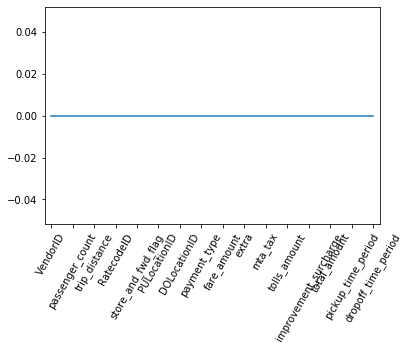

In [31]:
# Plot the coefficients
plt.plot(range(len(data.columns)), lasso_coef)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [68]:
# Create and fit the LassoCV model on the training set

lcv = LassoCV()

lcv.fit(X_train, y_train)

print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

Optimal alpha = 0.002


In [69]:
# Calculate R squared on the test set

r_squared = lcv.score(X_test, y_test)

print('The model explains {0:.1%} of the test set variance'.format(r_squared))

The model explains 99.8% of the test set variance


In [70]:
# Create a mask for coefficients not equal to zero

lcv_mask = lcv.coef_ != 0

print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

10 features out of 16 selected


In [75]:
list(zip(data.columns, lcv.coef_))

[('VendorID', -0.0013343364494424247),
 ('passenger_count', -0.0),
 ('trip_distance', 0.0),
 ('RatecodeID', -0.0009093643821384867),
 ('store_and_fwd_flag', 0.0),
 ('PULocationID', 0.0),
 ('DOLocationID', 0.0),
 ('payment_type', -0.017750257135925096),
 ('fare_amount', -10.796814086685346),
 ('extra', -0.4534267650218814),
 ('mta_tax', -0.04699802732561209),
 ('tolls_amount', -1.9713430821424414),
 ('improvement_surcharge', -0.021659228039724778),
 ('total_amount', 13.387321813948759),
 ('pickup_time_period', 0.0),
 ('dropoff_time_period', 5.9107252205773994e-05)]

- The lassocv model compresses the irrelevant features to 0. A sure way of identifying the relevant features.

- The compressed features to not add any value to the model and can be seen as noise or irrelevant.

In [76]:

reduced = data.loc[:, lcv_mask]
reduced.columns

Index(['VendorID', 'RatecodeID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'dropoff_time_period'],
      dtype='object')

# Linear Regression Residual Plot

- Residual shows the difference between the predicted value and the true value on the validation data.

In [0]:
residuals = y_val - pred

Text(0, 0.5, 'residuals')

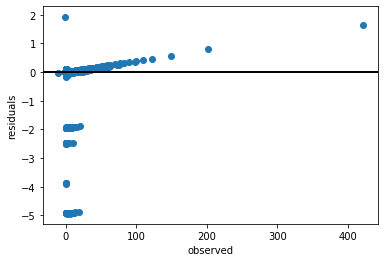

In [36]:
fig, ax = plt.subplots()
ax.scatter(y_val, residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('observed')
ax.set_ylabel('residuals')

- Let's look at the coefficint for each of our features.

In [37]:
list(zip(data.columns, reg.coef_))

[('VendorID', -0.0028439128489107647),
 ('passenger_count', -9.865133203557086e-06),
 ('trip_distance', 0.00272110004679413),
 ('RatecodeID', -0.0006327509561202746),
 ('store_and_fwd_flag', 3.8433138805950284e-05),
 ('PULocationID', 0.00047445677024484344),
 ('DOLocationID', 0.00044406474020638846),
 ('payment_type', -0.001662275136237765),
 ('fare_amount', -11.010747057724307),
 ('extra', -0.46435276135521264),
 ('mta_tax', -0.05058322810189735),
 ('tolls_amount', -2.0108747194020027),
 ('improvement_surcharge', -0.019413036093862565),
 ('total_amount', 13.620967658849066),
 ('pickup_time_period', 0.00031687416938320796),
 ('dropoff_time_period', 0.0007002911784407101)]

In [38]:
reg.intercept_

1.8110033586919616

- Intercept is on 1.81
- Will another model perform better?

#ElasticNet

In [40]:
el_model = ElasticNet(l1_ratio=0.2, alpha=0.01, random_state=42)
el_model.fit(X_train, y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.2,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

- Instantiate the elastic net model and pass in l1 regularization of 0.2 and alpha of 0.01.
- Fit the model on training set.

In [0]:
el_pred = el_model.predict(X_val)

In [42]:
list(zip(data.columns, el_model.coef_))

[('VendorID', -0.005534504259206016),
 ('passenger_count', 0.0009725812322060225),
 ('trip_distance', -0.0),
 ('RatecodeID', -0.06298025395199347),
 ('store_and_fwd_flag', -0.0),
 ('PULocationID', 0.0001948907218490471),
 ('DOLocationID', 0.00584516855889982),
 ('payment_type', -0.510768692229252),
 ('fare_amount', -4.943410507262785),
 ('extra', -0.18809621859170897),
 ('mta_tax', -0.0026386621136569952),
 ('tolls_amount', -0.9315756956016676),
 ('improvement_surcharge', -0.10328985520829524),
 ('total_amount', 6.949984163864964),
 ('pickup_time_period', 0.0),
 ('dropoff_time_period', 0.012019454202482838)]

- Get the coefficients of each features.

- A lot of features have coeficient close to zero and thus do not add any performance to the model.

- total amount has the heighest coeficient and look like the determinant factor in the model. 

In [43]:
el_model.intercept_

1.8109028629550648

- Intercept is the same as the linear regression model.

In [44]:
el_model.score(X_val, y_val)

0.8846540363621467

In [45]:
el_model.score(X_train, y_train)

0.886713258015232

- R2 score is 88% for both train and validation set.

In [46]:
el_mse = mean_squared_error(y_val, el_pred)
print("Mean Squared Error: {}".format(el_mse))

Mean Squared Error: 0.6900135385735222


In [47]:
rmse = np.sqrt(mean_squared_error(y_val, el_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.8306705355154487


Text(0, 0.5, 'residuals')

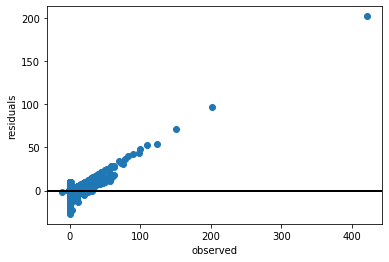

In [48]:
residuals = y_val - el_pred
fig, ax = plt.subplots()
ax.scatter(y_val, residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('observed')
ax.set_ylabel('residuals')

- Residual plot is better than that of the linear regression model.

# Tuning Elastic Net Hyperparameter

- Tune the hyperparameter of the elastic to find the best l1 regularization value that gives the model the best parameter.

In [49]:
parameters = {'l1_ratio':np.linspace(0,1,10)}

gridsearch_cv = GridSearchCV(el_model, param_grid=parameters, cv=3)

gridsearch_cv.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2874996.985696639, tolerance: 2395.6486707171143

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2842118.73628526, tolerance: 2370.0955185543894

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2829387.360811934, tolerance: 2386.888168230289



GridSearchCV(cv=3, error_score=nan,
             estimator=ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.2, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=42, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [50]:
r2 = gridsearch_cv.score(X_val, y_val)
print("Tuned ElasticNet Alpha: {}".format(gridsearch_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

Tuned ElasticNet Alpha: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.9933305760411675


- We can see that the best parameter for l1_ratio is 1.0 while the R2 score is 99%.

In [51]:
print("Tuned ElasticNet Best Score: {}".format(gridsearch_cv.best_score_))

Tuned ElasticNet Best Score: 0.9929159118522044


In [52]:
grid_pred = gridsearch_cv.predict(X_val)

grid_mse = mean_squared_error(y_val, grid_pred)
print("Tuned ElasticNet MSE Score: {}".format(grid_mse))

Tuned ElasticNet MSE Score: 0.03989730269651867


- MSE for the grid search model is better than the previous elastic net model.

In [53]:
grid_rmse = np.sqrt(grid_mse)

print("Tuned ElasticNet RMSE Score: {}".format(grid_rmse))

Tuned ElasticNet RMSE Score: 0.19974309173665725


- RMSE is far better than the previous non tuned model.

# Decision Tree Regressor

- Trying out decision tree regressor to see if we have a different result.

- The first tree model built will be without hyperparameters tuning.

In [54]:
from sklearn.tree import DecisionTreeRegressor

#instantiate the decision tree regressor
dt = DecisionTreeRegressor()


#fit the model on the training data
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
# perform prediction on the validaton set

dt_pred = dt.predict(X_val)

In [56]:
# print the r2 score on val set

dt_r2 = dt.score(X_val, y_val)

print('The R2 score is: {:.2f}'.format(dt_r2))

The R2 score is: 0.97


- R2 score is 98%. What are the mse and rmse score.

In [57]:
# get the mean squared error
dt_mse = mean_squared_error(y_val, dt_pred)

print("Test set MSE of dt: {:.2f}".format(dt_mse))

Test set MSE of dt: 0.16


- The decision tree model has a MSE of 14%. This is a bit high for our model.
- Will the model perfom better on the rmse?

In [58]:
dt_rmse = np.sqrt(dt_mse)

print("Test set RMSE of dt: {:.2f}".format(dt_rmse))

Test set RMSE of dt: 0.41


- On the rmse, the model performance is not suitable and can be further improved.

- Lets perform some hyperparameter tuning.

# Tuning Decision Tree Regressor

- First create a new decision tree model and passing max_depth-8, min_samples_leaf=0.13, random_state=3

In [0]:
new_dt = DecisionTreeRegressor( 
                               max_depth=7,
                              min_samples_leaf=0.13,
                              random_state=3)

- Tune the Decision tree regression model using the cross_val_score method of sklearn model selection.

- Used a 10 fold CV and print the mean of the rmse 

In [60]:
mse_cv_scores = - cross_val_score(new_dt, X_train, y_train, cv=5, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Compute the 10-folds CV RMSE
rmse_cv = (mse_cv_scores.mean())**(0.5)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rmse_cv))

CV RMSE: 1.79


- The mean rmse score is 1.79 which is quite okay for our model.

In [0]:
#fit the model on the train set
new_dt.fit(X_train, y_train)

#train prediction
new_dt_pred_train = new_dt.predict(X_train)


#test prediction
new_dt_pred_test = new_dt.predict(X_val)

In [62]:
#get the rmse of both the train and test set

rmse_train = (mean_squared_error(y_train, new_dt_pred_train))**(0.5)
rmse_val = (mean_squared_error(y_val, new_dt_pred_test))**(0.5)


# Print RMSE_train
print('Train RMSE: {:.2f}'.format(rmse_train))

print('Test RMSE: {:.2f}'.format(rmse_val))

Train RMSE: 1.79
Test RMSE: 1.85


- Train score is 1.79 and Test score is 1.85 is not bad. A little bias though on the model.

In [0]:
# Select 10 features with RFE on a GradientBoostingRegressor, drop 2 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=2, verbose=1)

rfe_gb.fit(X_train, y_train)

# Gradient Boosting Regression

- Intsatiate a gradient boosting regression model with a max_depth of 4, n_estimator of 200 and random_state of 2

In [0]:
# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            random_state=2)

In [64]:
# Fit gb to the training set
gb.fit(X_train, y_train)



GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# Predict test set labels
gb_pred = gb.predict(X_val)

In [66]:
# Compute MSE
mse_test = mean_squared_error(y_val, gb_pred)

# Compute RMSE
rmse_test = mse_test ** 0.5

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 0.574


- Gradient Boosting performed poorly.

# Feature Selection with RFE for Gradient Boosting Algorithm

- Using recurcive feature engineering to select features from the Gradient boosting model.

In [78]:
# Select 10 features with RFE on a GradientBoostingRegressor, drop 2 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=2, verbose=1)

rfe_gb.fit(X_train, y_train)

Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.


RFE(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                        criterion='friedman_mse', init=None,
                                        learning_rate=0.1, loss='ls',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_iter_no_change=None,
                                        presort='deprecated', random_state=None,
                                        subsample=1.0, tol=0.0001,
                                        validation_fraction=0.1, verbose=0,
                                        warm_start=False),
    n_f

In [79]:
# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_val, y_val)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

The model can explain 85.6% of the variance in the test set


In [0]:
mask = rfe_gb.support_

In [83]:
list(zip(data.columns, mask))

[('VendorID', False),
 ('passenger_count', False),
 ('trip_distance', True),
 ('RatecodeID', True),
 ('store_and_fwd_flag', False),
 ('PULocationID', True),
 ('DOLocationID', True),
 ('payment_type', True),
 ('fare_amount', True),
 ('extra', True),
 ('mta_tax', False),
 ('tolls_amount', True),
 ('improvement_surcharge', True),
 ('total_amount', True),
 ('pickup_time_period', False),
 ('dropoff_time_period', False)]

- All the columns mapped as true are the selected features.

In [84]:
kept_feature = data.loc[:, mask]
kept_feature.columns

Index(['trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

- Above we can see the features the rfe selected for us.